# Data Dive Week 10: Fitting and Evaluating Classification Models

Today we revisit our Kiva data to review model performance and tradeoffs between different classification methods. We'll use logistic regression, decision trees, random forests, and gradient boosting machines to predict whether loan requests posted on [Kiva.org](kiva.org) recevie funding. We'll be using `scikit-learn` for all of the models in today's exercise. 


***




![alt text](https://designtoimprovelife.dk/wp-content/uploads/2009/08/KIVA.jpg)

Kiva is an international nonprofit, founded in 2005 and based in San Francisco, with a mission to connect people through lending to alleviate poverty. Kiva seeks to celebrate and support people looking to create a better future for themselves, their families and their communities.

*By lending as little as $25 on Kiva, anyone can help a borrower start or grow a business, go to school, access clean energy or realize their potential. For some, it’s a matter of survival, for others it’s the fuel for a life-long ambition.*

## Today's Modeling Objective
Our focus today will be determining whether microfinance projects on the site [Kiva.org](kiva.org) receive funding or not using a host of features made available by Kiva, along with some features we'll design ourselves. 

Today's data is a subsample of projects in Kenya, one of Kiva's most active countries for lending. We'll be working with 18,000 observations, 12,000 of which were funded. 

Documentation on the data is available on [Kiva's website](http://build.kiva.org/docs/data/basic_types).

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold, train_test_split

warnings.filterwarnings("ignore")
random_state = 20181112

In [2]:
df = pd.read_csv('https://grantmlong.com/data/kiva_kenya_sample.csv')
print(df.shape)
print(list(df))
df.head()

(18000, 25)
['LOAN_ID', 'DESCRIPTION', 'FUNDED_AMOUNT', 'LOAN_AMOUNT', 'STATUS', 'ACTIVITY_NAME', 'SECTOR_NAME', 'LOAN_USE', 'TOWN_NAME', 'CURRENCY', 'PARTNER_ID', 'POSTED_TIME', 'PLANNED_EXPIRATION_TIME', 'DISBURSE_TIME', 'RAISED_TIME', 'LENDER_TERM', 'NUM_LENDERS_TOTAL', 'NUM_JOURNAL_ENTRIES', 'NUM_BULK_ENTRIES', 'TAGS', 'BORROWER_NAMES', 'BORROWER_GENDERS', 'BORROWER_PICTURED', 'REPAYMENT_INTERVAL', 'DISTRIBUTION_MODEL']


,LOAN_ID,DESCRIPTION,FUNDED_AMOUNT,LOAN_AMOUNT,STATUS,ACTIVITY_NAME,SECTOR_NAME,LOAN_USE,TOWN_NAME,CURRENCY,...,LENDER_TERM,NUM_LENDERS_TOTAL,NUM_JOURNAL_ENTRIES,NUM_BULK_ENTRIES,TAGS,BORROWER_NAMES,BORROWER_GENDERS,BORROWER_PICTURED,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL
0,854452,"Janepher, pictured above, is a group leader an...",725.0,1000.0,expired,Agriculture,Agriculture,to buy cost-efficient maize seeds and fertiliz...,Webuye,KES,...,11.0,15,1,1,"#Eco-friendly, #Sustainable Ag, #Technology, #...","Teresa, Janepher, Joseph, Jane, Phylis J, Mild...","female, female, male, female, female, female, ...","true, true, true, true, true, true, true, true...",bullet,field_partner
1,868233,John is a married man. He has two children. He...,825.0,1100.0,expired,Grocery Store,Food,buy more stock of maize to produce maize flou...,Nakuru,KES,...,14.0,14,1,1,"#Parent, #Repeat Borrower, #Vegan",JOHN,male,true,monthly,field_partner
2,1429009,Margaret is a single mother and lives with her...,275.0,500.0,expired,Farming,Agriculture,to buy hybrid seeds and fertilizers to use on ...,Siongiroi,KES,...,20.0,11,1,1,"#Eco-friendly, #Woman Owned Biz",Margaret,female,true,monthly,field_partner
3,1077128,Agriphine is a proud mother of angelic-looking...,225.0,1000.0,expired,Farming,Agriculture,to buy farm supplies and seeds in order to exp...,Chuka,KES,...,20.0,7,1,1,"#Parent, #Woman Owned Biz",Agriphine,female,true,monthly,field_partner
4,825980,Bernard is 32 years. He is married to Caroline...,275.0,500.0,expired,Butcher Shop,Food,to add stocks of pork meat.,Kisumu,KES,...,14.0,8,1,1,"user_favorite, #Parent, #Repeat Borrower",BERNARD,male,true,monthly,field_partner


# Tidying Up Our Data

There are a couple of different things we'll want to off the bat: 
 1. Create a target variable
 2. Generate a more usable version of the `POSTED_TIME` column.
 3. Generate a variable with the amount of planned time before expiration for each project. 
 4. Generate boolean variables for each of the following categorical columns:
   * `SECTOR_NAME`
   * `ACTIVITY_NAME`
   * `REPAYMENT_INTERVAL`
 5. Create boolean variables for a handful of other free text and categorical columns, including:
   * `BORROWER_PICTURED`
   * `BORROWER_GENDERS`
   * `DISTRIBUTION_MODEL`
 
 

In [3]:
df.STATUS.value_counts()

funded     12000
expired     6000
Name: STATUS, dtype: int64

In [4]:
df['success'] = (df.STATUS=='funded')*1


In [5]:
df.POSTED_TIME.head()

0    2015-03-12 12:14:55.000 +0000
1    2015-04-10 10:47:35.000 +0000
2    2017-12-06 10:12:14.000 +0000
3    2016-05-27 13:05:40.000 +0000
4    2015-01-09 09:10:57.000 +0000
Name: POSTED_TIME, dtype: object

In [6]:
df['posted_year'] = pd.to_datetime(df.POSTED_TIME).dt.year
df['posted_duration'] = (pd.to_datetime(df.PLANNED_EXPIRATION_TIME)
                             - pd.to_datetime(df.POSTED_TIME)
                            ).dt.days
                            

In [7]:
sector_names = ['sector_' + name.lower() for name in df.SECTOR_NAME.unique()]
for name in df.SECTOR_NAME.unique():
    df['sector_' + name.lower()] = (df.SECTOR_NAME==name)*1

activity_names = ['activity_' + name.lower() for name in df.ACTIVITY_NAME.unique()]
for name in df.ACTIVITY_NAME.unique():
    df['activity_' + name.lower()] = (df.ACTIVITY_NAME==name)*1

repayment_types = ['repayment_' + interval.lower() for interval in df.REPAYMENT_INTERVAL.unique()]
for interval in df.REPAYMENT_INTERVAL.unique():
    df['repayment_' + interval.lower()] = (df.REPAYMENT_INTERVAL==interval)*1


In [8]:
other_names = ['has_borrower_pic', 'has_female_borrower', 'direct_distribution', 'currency_usd']

df['has_borrower_pic'] = df.BORROWER_PICTURED.str.contains('true')*1
df['has_borrower_pic'] = df['has_borrower_pic'].fillna(0)

df['has_female_borrower'] = df.BORROWER_GENDERS.str.contains('female')*1
df['has_female_borrower'] = df['has_female_borrower'].fillna(0)

df['direct_distribution'] = (df.DISTRIBUTION_MODEL=='direct')*1

df['currency_usd'] = (df.CURRENCY=='USD')*1


# Data Handling

In [9]:
features = (['posted_year', 'posted_duration', 'LOAN_AMOUNT', 'LENDER_TERM', 'NUM_JOURNAL_ENTRIES'] 
            + repayment_types + sector_names + activity_names 
            + other_names
           )

model_df = df[(features + ['success'])].dropna().reset_index()

train_df, holdout_df, y_train, y_holdout = train_test_split(
    model_df[features], 
    model_df['success'], test_size=0.1,
    random_state=random_state)



train_df['success'] = y_train
holdout_df['success'] = y_holdout

train_df.reset_index(inplace=True)
holdout_df.reset_index(inplace=True)

print(train_df.shape[0], train_df.success.mean())
print(holdout_df.shape[0], holdout_df.success.mean())

14297 0.621668881583549
1589 0.6280679672750157


# Model Training

Let's take a quick look at all of our classification model options using cross validation. For the tree based models, we'll use the hyperparameter `max_depth=6` as a naive attempt at voiding overfitting before we dig deeper.

##### Let's fit and score the model, this time using cross validation:

In [10]:
k_fold = KFold(n_splits=5, random_state=random_state)

In [11]:
def get_cv_results(classifier):
    
    results = []
    for train, test in k_fold.split(train_df):
        classifier.fit(train_df.loc[train, features], train_df.loc[train, 'success'])
        y_predicted = classifier.predict(train_df.loc[test, features])
        accuracy = accuracy_score(train_df.loc[test, 'success'], y_predicted)
        results.append(accuracy)
    
    return np.mean(results), np.std(results)


#### First, let's look at the cv performance of Logistic Regression

In [12]:
logreg = LogisticRegression(
    random_state=random_state, 
    solver='lbfgs'
)

get_cv_results(logreg)

(0.7644260915719467, 0.010979146454348028)

#### Next, let's take a naive attempt to beat Logistic Regression using a Tree

In [13]:
dtree = DecisionTreeClassifier(
    random_state=random_state, 
    max_depth=6
)

get_cv_results(dtree)

(0.8217106573035219, 0.0024906435410496208)

#### Looks like a non-linear method gives us a big boost. Let's try a Random Forest.

In [14]:
rforest = RandomForestClassifier(
    random_state=random_state, 
    max_depth=6,
    n_estimators=100
)

get_cv_results(rforest)

(0.8154853890425768, 0.0032988376919777453)

#### Finally, let's take a naive approach to Gradient Boosting.

In [15]:
gbm = GradientBoostingClassifier(
    random_state=random_state, 
    max_depth=6,
    n_estimators=100
)

get_cv_results(gbm)

(0.8613691764688618, 0.003947793716135799)

### Learning Curves, Revisited

Now that we're working with a more complex data set, we should be able to build more robust learning curves than we had experience with when we were using the  

In [16]:
hp_values = range(1,50, 2)
all_mu = []
all_sigma = []

for m in hp_values:

    dtree=DecisionTreeClassifier(
        criterion='entropy', 
        random_state=random_state, 
        max_depth=m,
    )

    mu, sigma = get_cv_results(dtree)
    all_mu.append(mu)
    all_sigma.append(sigma)
    
    print(m, mu, sigma)

1 0.7057419215971157 0.006197712587708798
3 0.7747080621372332 0.009441268420865052
5 0.8133173367381132 0.005966408795355334
7 0.8233893214166038 0.005961895906191497
9 0.8313628169661749 0.005254125604413617
11 0.8410155147405934 0.0032442400799333236
13 0.8415746373248997 0.005544680690834588
15 0.8409455602110377 0.0029511699042006935
17 0.8387077245943984 0.003306029540725475
19 0.8364695710026243 0.003056774265880661
21 0.8362592671406942 0.0021894358037878414
23 0.8347902953988999 0.0033983751530999467
25 0.8311532468930161 0.0030919273854788116
27 0.8333216905514911 0.003947312027337628
29 0.8307337398523128 0.0022859692370877506
31 0.8303139637557265 0.0018769514022197087
33 0.828634932748259 0.003799783904552117
35 0.8292645724335126 0.0024081721767429177
37 0.8284953905835334 0.0010897286961143453
39 0.828075981381333 0.0010243108829064594
41 0.8278657753579054 0.0014648761806115424
43 0.8281455200972514 0.0017175627267847198
45 0.8277957474494725 0.001936419524087309
47 0.8

Text(0.5, 0, 'Max Depth')

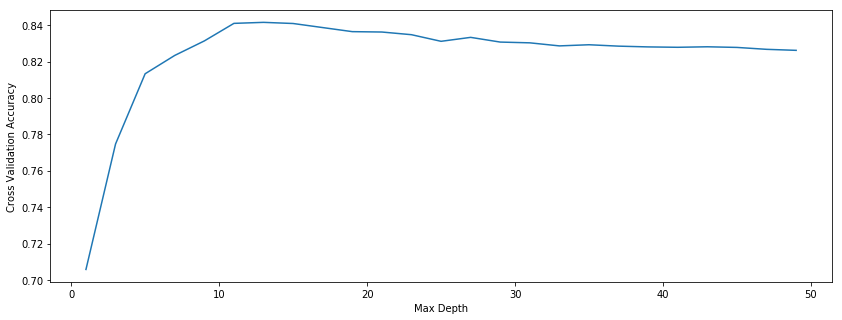

In [17]:
plt.figure(figsize=(14, 5))
plt.plot(hp_values, all_mu)
plt.ylabel('Cross Validation Accuracy')
plt.xlabel('Max Depth')

Text(0.5, 0, 'Max Depth')

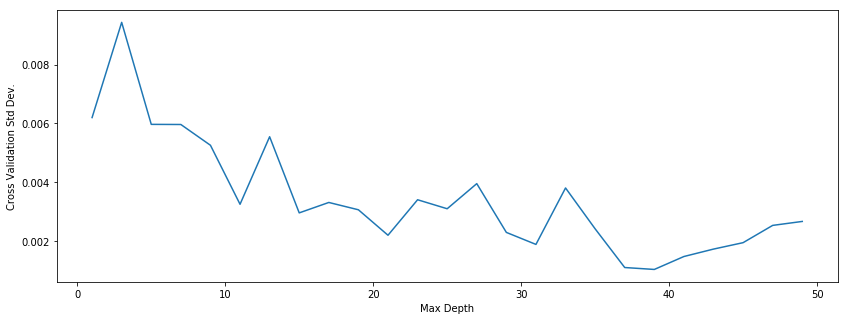

In [18]:
plt.figure(figsize=(14, 5))
plt.plot(hp_values, all_sigma)
plt.ylabel('Cross Validation Std Dev.')
plt.xlabel('Max Depth')

# Evaluating Model Performance

We can use ROC curves to look at how our models perform across a variety of threshholds against our holdout data. 


In [19]:
def plot_roc(classifier, label, color):

    classifier.fit(train_df[features], train_df['success'])
    y_prob = classifier.predict_proba(holdout_df[features])
    
    fpr, tpr, thresh = roc_curve(holdout_df['success'], y_prob[:,1])
    plt.plot(fpr, tpr,
             label=label,
             color=color, linewidth=3)

    auc = roc_auc_score(holdout_df['success'], y_prob[:,1])
    
    print('AUC: %0.3f (%s)' % (auc, label))
 

AUC: 0.871 (Logistic Regression)
AUC: 0.921 (Decision Tree)
AUC: 0.923 (Random Forest)
AUC: 0.953 (GBM)


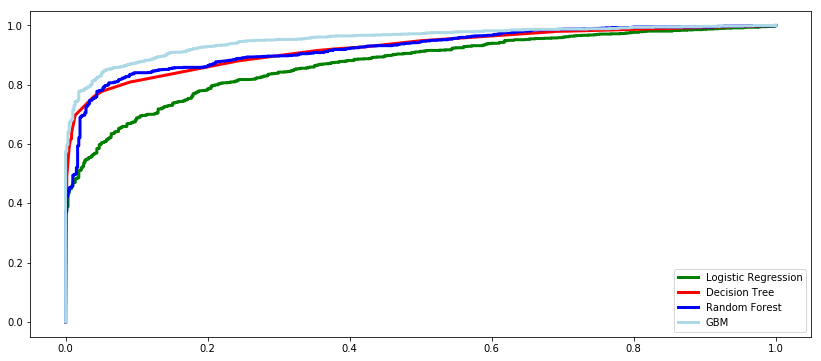

In [20]:
f1 = plt.figure(figsize=(14,6))

logreg = LogisticRegression(
    random_state=random_state, 
    solver='lbfgs'
)
plot_roc(logreg, 'Logistic Regression', 'green')

dtree = DecisionTreeClassifier(
    random_state=random_state, 
    max_depth=6
)
plot_roc(dtree, 'Decision Tree', 'red')

rforest = RandomForestClassifier(
    random_state=random_state, 
    max_depth=6,
    n_estimators=100
)
plot_roc(rforest, 'Random Forest', 'blue')

gbm = GradientBoostingClassifier(
    random_state=random_state, 
    max_depth=6,
    n_estimators=100
)
plot_roc(gbm, 'GBM', 'lightblue')

plt.legend(loc='lower right')